# Subject-Grouped K-Fold Evaluation
This notebook mirrors the baseline mHealth pipeline while evaluating grouped subject-wise folds.

In [1]:

import copy
from collections import Counter
from dataclasses import dataclass
from pathlib import Path
from typing import Dict, Iterable, List, Optional, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

try:
    from sklearn.metrics import (
        ConfusionMatrixDisplay,
        classification_report,
        confusion_matrix,
        f1_score,
    )
except ImportError:
    ConfusionMatrixDisplay = classification_report = confusion_matrix = f1_score = None
    print("Warning: scikit-learn is not available. Metric reports will be limited.")


In [2]:

plt.rc("font", family="Malgun Gothic")
plt.rc("axes", unicode_minus=False)


In [3]:

DATA_DIR = Path.cwd() / "MHEALTHDATASET"

COLUMN_NAMES = [
    "acc_chest_x", "acc_chest_y", "acc_chest_z",
    "ecg_1", "ecg_2",
    "acc_ankle_x", "acc_ankle_y", "acc_ankle_z",
    "gyro_ankle_x", "gyro_ankle_y", "gyro_ankle_z",
    "mag_ankle_x", "mag_ankle_y", "mag_ankle_z",
    "acc_wrist_x", "acc_wrist_y", "acc_wrist_z",
    "gyro_wrist_x", "gyro_wrist_y", "gyro_wrist_z",
    "mag_wrist_x", "mag_wrist_y", "mag_wrist_z",
    "label",
]

FEATURE_COLUMNS = COLUMN_NAMES[:-1]

ACTIVITY_MAP = {
    1: "Standing still",
    2: "Sitting and relaxing",
    3: "Lying down",
    4: "Walking",
    5: "Climbing stairs",
    6: "Waist bends forward",
    7: "Frontal arms elevation",
    8: "Knees bending (crouch)",
    9: "Cycling",
    10: "Jogging",
    11: "Running",
    12: "Jump front & back",
}

SAMPLING_RATE_HZ = 50

subject_files = sorted(DATA_DIR.glob("mHealth_subject*.log"))

if not subject_files:
    raise FileNotFoundError(f"Could not find any subject files under {DATA_DIR}")

print(f"Subject files: {len(subject_files)}")
print(subject_files[:3])


Subject files: 10
[WindowsPath('c:/Users/이예일/OneDrive/바탕 화면/대학/3학년2학기/기학프/MHEALTHDATASET/mHealth_subject1.log'), WindowsPath('c:/Users/이예일/OneDrive/바탕 화면/대학/3학년2학기/기학프/MHEALTHDATASET/mHealth_subject10.log'), WindowsPath('c:/Users/이예일/OneDrive/바탕 화면/대학/3학년2학기/기학프/MHEALTHDATASET/mHealth_subject2.log')]


In [4]:

def summarize_labels(files: Iterable[Path], chunksize: int = 200_000) -> Tuple[Dict[str, Dict[int, int]], Dict[int, int]]:
    per_subject: Dict[str, Dict[int, int]] = {}
    total_counter: Counter = Counter()
    for path in files:
        counter = Counter()
        for chunk in pd.read_csv(
            path,
            sep="	",
            header=None,
            usecols=[23],
            names=["label"],
            chunksize=chunksize,
        ):
            labels = chunk["label"].astype(int)
            chunk_counts = Counter(labels)
            counter.update(chunk_counts)
            total_counter.update(chunk_counts)
        per_subject[path.name] = dict(sorted(counter.items()))
    return per_subject, dict(sorted(total_counter.items()))


per_subject_counts, total_counts = summarize_labels(subject_files)

summary_rows = []
label_ids = sorted({label for counts in per_subject_counts.values() for label in counts})
for name, counts in per_subject_counts.items():
    row = {"subject": name, "samples": sum(counts.values())}
    for label in label_ids:
        row[f"L{label:02d}"] = counts.get(label, 0)
    summary_rows.append(row)

label_summary_df = pd.DataFrame(summary_rows).set_index("subject")
display(label_summary_df)

print("Total samples:", sum(total_counts.values()))
print("Label distribution:", total_counts)


,samples,L00,L01,L02,L03,L04,L05,L06,L07,L08,L09,L10,L11,L12
subject,,,,,,,,,,,,,,
mHealth_subject1.log,161280,126106,3072,3072,3072,3072,3072,3072,3072,3379,3072,3072,3072,1075
mHealth_subject10.log,98304,64614,3072,3072,3072,3072,3072,2458,2765,2867,3072,3072,3072,1024
mHealth_subject2.log,130561,95029,3072,3072,3072,3072,3072,3174,3328,3430,3072,3072,3072,1024
mHealth_subject3.log,122112,86732,3072,3072,3072,3072,3072,3226,3379,3175,3072,3072,3072,1024
mHealth_subject4.log,116736,81408,3072,3072,3072,3072,3072,3328,3277,3123,3072,3072,3072,1024
mHealth_subject5.log,119808,85861,3072,3072,3072,3072,3072,2765,2868,2714,3072,3072,3072,1024
mHealth_subject6.log,98304,66099,3072,3072,3072,3072,3072,2202,2099,2304,3072,3072,3072,1024
mHealth_subject7.log,104448,70195,3072,3072,3072,3072,3072,3072,2765,2816,3072,3072,3072,1024
mHealth_subject8.log,129024,95692,3072,3072,3072,3072,3072,2151,3021,2560,3072,3072,3072,1024


Total samples: 1215745
Label distribution: {0: 872550, 1: 30720, 2: 30720, 3: 30720, 4: 30720, 5: 30720, 6: 28315, 7: 29441, 8: 29337, 9: 30720, 10: 30720, 11: 30720, 12: 10342}


In [5]:

def compute_feature_stats(files: Iterable[Path], chunksize: int = 100_000) -> pd.DataFrame:
    min_vals = max_vals = sum_vals = sumsq_vals = None
    count = 0

    for path in files:
        for chunk in pd.read_csv(
            path,
            sep="	",
            header=None,
            names=COLUMN_NAMES,
            usecols=range(len(COLUMN_NAMES)),
            chunksize=chunksize,
        ):
            data = chunk[FEATURE_COLUMNS].to_numpy(dtype=np.float64)
            if min_vals is None:
                min_vals = data.min(axis=0)
                max_vals = data.max(axis=0)
                sum_vals = data.sum(axis=0)
                sumsq_vals = np.square(data).sum(axis=0)
                count = data.shape[0]
            else:
                min_vals = np.minimum(min_vals, data.min(axis=0))
                max_vals = np.maximum(max_vals, data.max(axis=0))
                sum_vals += data.sum(axis=0)
                sumsq_vals += np.square(data).sum(axis=0)
                count += data.shape[0]

    mean = sum_vals / count
    variance = sumsq_vals / count - np.square(mean)
    std = np.sqrt(np.maximum(variance, 1e-12))

    return pd.DataFrame(
        {
            "min": min_vals,
            "max": max_vals,
            "mean": mean,
            "std": std,
        },
        index=FEATURE_COLUMNS,
    )


feature_stats_df = compute_feature_stats(subject_files)
display(feature_stats_df.round(4))

normalization_stats = {
    "mean": feature_stats_df["mean"].to_numpy(),
    "std": feature_stats_df["std"].replace(0, 1e-6).to_numpy(),
}


,min,max,mean,std
acc_chest_x,-22.4380,19.0940,-8.5224,4.0753
acc_chest_y,-20.1880,20.9270,-0.2140,2.1390
acc_chest_z,-18.4010,26.1960,-1.0559,3.5742
ecg_1,-8.6196,8.5149,-0.0051,0.7466
ecg_2,-8.6196,8.5191,-0.0045,0.7270
acc_ankle_x,-22.1460,20.0540,1.4942,3.8265
acc_ankle_y,-19.6190,21.1610,-9.6929,4.1713
acc_ankle_z,-19.3730,25.0150,-0.9548,5.4618
gyro_ankle_x,-2.1466,60.4840,-0.0016,0.4912
gyro_ankle_y,-7.7899,2.0113,-0.6166,0.3546


In [6]:

def majority_vote(labels: np.ndarray, ignore_zero: bool = False) -> int:
    if ignore_zero:
        labels = labels[labels != 0]
        if labels.size == 0:
            return 0
    values, counts = np.unique(labels, return_counts=True)
    return int(values[np.argmax(counts)])


def generate_windows(
    df: pd.DataFrame,
    window_size: int = 250,
    step_size: int = 125,
    include_null: bool = False,
    majority_ignore_zero: bool = True,
) -> Tuple[np.ndarray, np.ndarray]:
    features = df[FEATURE_COLUMNS].to_numpy(dtype=np.float32)
    labels = df["label"].to_numpy(dtype=np.int64)

    windows: List[np.ndarray] = []
    window_labels: List[int] = []

    for start in range(0, len(df) - window_size + 1, step_size):
        end = start + window_size
        window = features[start:end]
        label = majority_vote(labels[start:end], ignore_zero=majority_ignore_zero)
        if not include_null and label == 0:
            continue
        windows.append(window)
        window_labels.append(label)

    if not windows:
        return (
            np.empty((0, window_size, len(FEATURE_COLUMNS)), dtype=np.float32),
            np.empty(0, dtype=np.int64),
        )

    return np.stack(windows), np.array(window_labels, dtype=np.int64)


example_df = pd.read_csv(
    subject_files[0],
    sep="	",
    header=None,
    names=COLUMN_NAMES,
    nrows=10_000,
)
example_df["label"] = example_df["label"].astype(int)
example_windows, example_labels = generate_windows(example_df, window_size=250, step_size=125)
print(f"Example windows: {len(example_windows)}, shape={example_windows.shape}")
print("Label counts:", Counter(example_labels))


Example windows: 26, shape=(26, 250, 23)
Label counts: Counter({np.int64(1): 26})


In [7]:

class MHealthWindowDataset(Dataset):
    """Windowed mHealth dataset with optional normalization."""

    def __init__(
        self,
        subjects: Iterable[int],
        data_dir: Path = DATA_DIR,
        window_size: int = 250,
        step_size: int = 125,
        include_null: bool = False,
        normalization: Optional[Dict[str, np.ndarray]] = None,
    ) -> None:
        self.subjects = list(subjects)
        self.data_dir = data_dir
        self.window_size = window_size
        self.step_size = step_size
        self.include_null = include_null
        self.normalization = normalization

        self.inputs: torch.Tensor
        self.targets: torch.Tensor
        self._prepare()

    def _load_subject(self, subject_id: int) -> pd.DataFrame:
        path = self.data_dir / f"mHealth_subject{subject_id}.log"
        if not path.exists():
            raise FileNotFoundError(path)
        df = pd.read_csv(path, sep="	", header=None, names=COLUMN_NAMES)
        df["label"] = df["label"].astype(int)

        features = df[FEATURE_COLUMNS].to_numpy(dtype=np.float32)
        if self.normalization is not None:
            mean = np.asarray(self.normalization["mean"], dtype=np.float32)
            std = np.asarray(self.normalization["std"], dtype=np.float32)
            features = (features - mean) / std
        df.loc[:, FEATURE_COLUMNS] = features
        return df

    def _prepare(self) -> None:
        window_tensors: List[torch.Tensor] = []
        label_tensors: List[torch.Tensor] = []

        for subject_id in self.subjects:
            df = self._load_subject(subject_id)
            windows, labels = generate_windows(
                df,
                window_size=self.window_size,
                step_size=self.step_size,
                include_null=self.include_null,
                majority_ignore_zero=not self.include_null,
            )
            if windows.size == 0:
                continue
            window_tensor = torch.from_numpy(windows).permute(0, 2, 1).contiguous()
            label_tensor = torch.from_numpy(labels)
            window_tensors.append(window_tensor)
            label_tensors.append(label_tensor)

        if window_tensors:
            self.inputs = torch.cat(window_tensors, dim=0)
            self.targets = torch.cat(label_tensors, dim=0)
        else:
            num_features = len(FEATURE_COLUMNS)
            self.inputs = torch.empty((0, num_features, self.window_size), dtype=torch.float32)
            self.targets = torch.empty((0,), dtype=torch.long)

    def __len__(self) -> int:
        return self.targets.shape[0]

    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        return self.inputs[idx], self.targets[idx]


In [8]:

torch.manual_seed(42)
np.random.seed(42)

example_dataset = MHealthWindowDataset([1], window_size=250, step_size=125, normalization=normalization_stats)
print(f"Subject 1 windows: {len(example_dataset)}")


Subject 1 windows: 305


In [9]:
class LSTMBaseline(nn.Module):
    """Bi-layer LSTM baseline for mHealth classification."""

    def __init__(
        self,
        in_channels: int = len(FEATURE_COLUMNS),
        hidden_size: int = 128,
        num_layers: int = 2,
        bidirectional: bool = True,
        dropout: float = 0.3,
        num_classes: int = len(ACTIVITY_MAP) + 1,
    ) -> None:
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=in_channels,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
            bidirectional=bidirectional,
        )
        self.dropout = nn.Dropout(p=dropout)
        self.classifier = nn.Linear(hidden_size * (2 if bidirectional else 1), num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x.permute(0, 2, 1)
        outputs, _ = self.lstm(x)
        pooled = self.dropout(outputs[:, -1])
        return self.classifier(pooled)

default_device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {default_device}")

@dataclass
class TrainConfig:
    epochs: int = 30
    lr: float = 1e-3
    weight_decay: float = 1e-4
    grad_clip: Optional[float] = None
    device: str = default_device

model = LSTMBaseline()
print(model)


Using device: cpu
LSTMBaseline(
  (lstm): LSTM(23, 128, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (classifier): Linear(in_features=256, out_features=13, bias=True)
)


In [10]:

def create_class_weights(labels: Iterable[int], ignore_zero: bool = False) -> torch.Tensor:
    counts = Counter(labels)
    if ignore_zero and 0 in counts:
        counts.pop(0)
    if not counts:
        return torch.ones(len(ACTIVITY_MAP) + 1, dtype=torch.float32)
    max_count = max(counts.values())
    weights = torch.ones(len(ACTIVITY_MAP) + 1, dtype=torch.float32)
    for label, count in counts.items():
        weights[label] = max_count / count
    return weights


def train_one_epoch(
    model: nn.Module,
    dataloader: DataLoader,
    criterion,
    optimizer,
    device: str,
    grad_clip: Optional[float] = None,
) -> Tuple[float, float]:
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, targets in dataloader:
        inputs = inputs.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        if grad_clip is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()

        running_loss += loss.item() * targets.size(0)
        _, preds = torch.max(outputs, dim=1)
        correct += (preds == targets).sum().item()
        total += targets.size(0)
    return running_loss / total, correct / total


def evaluate(model: nn.Module, dataloader: DataLoader, criterion, device: str) -> Tuple[float, float]:
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_loss += loss.item() * targets.size(0)
            _, preds = torch.max(outputs, dim=1)
            correct += (preds == targets).sum().item()
            total += targets.size(0)
    return running_loss / total, correct / total


def predict(model: nn.Module, dataloader: DataLoader, device: str) -> Tuple[np.ndarray, np.ndarray]:
    model.eval()
    all_preds: List[np.ndarray] = []
    all_targets: List[np.ndarray] = []
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            all_preds.append(preds)
            all_targets.append(targets.numpy())
    return np.concatenate(all_preds), np.concatenate(all_targets)


Fold 1: test=(1, 2), val=(3, 4), train=[5, 6, 7, 8, 9, 10]
Windows - train: 1770, val: 615, test: 613
  epoch 01 | train_loss=2.3917 acc=0.328 | val_loss=2.1330 acc=0.514
  epoch 05 | train_loss=0.3396 acc=0.906 | val_loss=0.8506 acc=0.834
  epoch 10 | train_loss=0.0657 acc=0.987 | val_loss=0.8223 acc=0.893
  epoch 15 | train_loss=0.0082 acc=1.000 | val_loss=1.0031 acc=0.885
  epoch 20 | train_loss=0.3533 acc=0.895 | val_loss=1.1421 acc=0.745
  epoch 25 | train_loss=0.0770 acc=0.980 | val_loss=1.0847 acc=0.842
  epoch 30 | train_loss=0.0071 acc=0.999 | val_loss=1.2591 acc=0.833


C:\Users\이예일\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\이예일\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\이예일\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

                        precision    recall  f1-score   support

        Standing still      1.000     1.000     1.000        52
  Sitting and relaxing      0.000     0.000     0.000        52
            Lying down      1.000     1.000     1.000        54
               Walking      0.736     1.000     0.848        53
       Climbing stairs      0.800     0.963     0.874        54
   Waist bends forward      1.000     0.925     0.961        53
Frontal arms elevation      0.519     1.000     0.683        56
Knees bending (crouch)      0.920     0.780     0.844        59
               Cycling      1.000     1.000     1.000        53
               Jogging      0.625     0.283     0.390        53
               Running      0.537     0.667     0.595        54
     Jump front & back      1.000     0.950     0.974        20

              accuracy                          0.791       613
             macro avg      0.761     0.797     0.764       613
          weighted avg      0.750     

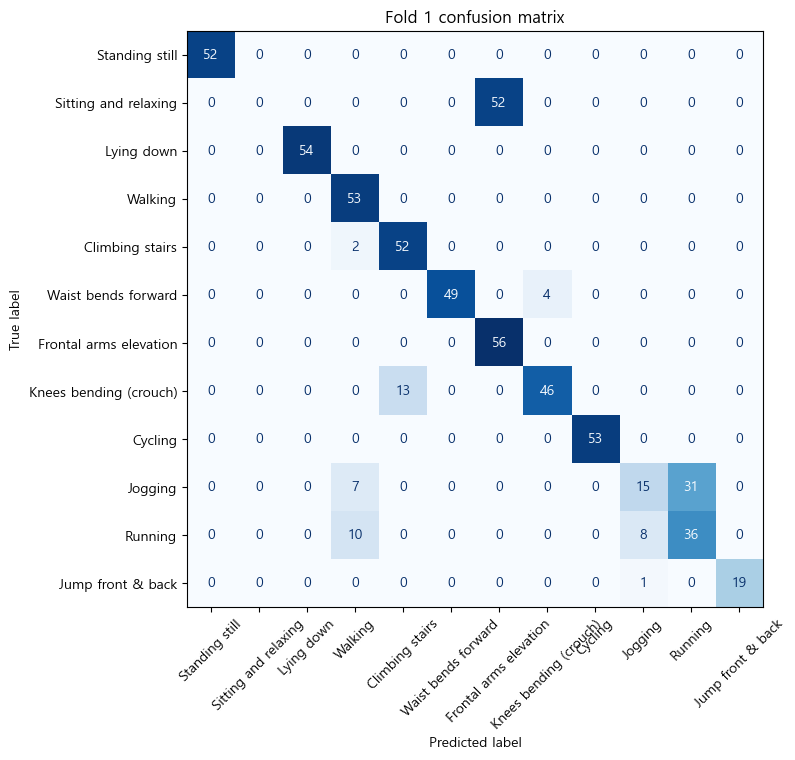

Fold 2: test=(3, 4), val=(5, 6), train=[1, 2, 7, 8, 9, 10]
Windows - train: 1805, val: 578, test: 615
  epoch 01 | train_loss=2.4254 acc=0.303 | val_loss=2.2159 acc=0.289
  epoch 05 | train_loss=0.5120 acc=0.837 | val_loss=1.1500 acc=0.671
  epoch 10 | train_loss=0.3830 acc=0.866 | val_loss=1.2846 acc=0.612
  epoch 15 | train_loss=0.1296 acc=0.967 | val_loss=0.8460 acc=0.765
  epoch 20 | train_loss=0.0336 acc=0.993 | val_loss=0.7706 acc=0.824
  epoch 25 | train_loss=0.0668 acc=0.981 | val_loss=0.8101 acc=0.815
  epoch 30 | train_loss=0.0465 acc=0.987 | val_loss=0.7872 acc=0.820


C:\Users\이예일\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\이예일\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\이예일\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le

                        precision    recall  f1-score   support

        Standing still      0.885     1.000     0.939        54
  Sitting and relaxing      0.000     0.000     0.000        54
            Lying down      1.000     1.000     1.000        53
               Walking      1.000     1.000     1.000        54
       Climbing stairs      0.803     1.000     0.891        53
   Waist bends forward      1.000     1.000     1.000        57
Frontal arms elevation      0.649     0.877     0.746        57
Knees bending (crouch)      0.750     0.944     0.836        54
               Cycling      1.000     1.000     1.000        53
               Jogging      1.000     1.000     1.000        53
               Running      1.000     1.000     1.000        53
     Jump front & back      1.000     1.000     1.000        20

              accuracy                          0.896       615
             macro avg      0.841     0.902     0.868       615
          weighted avg      0.831     

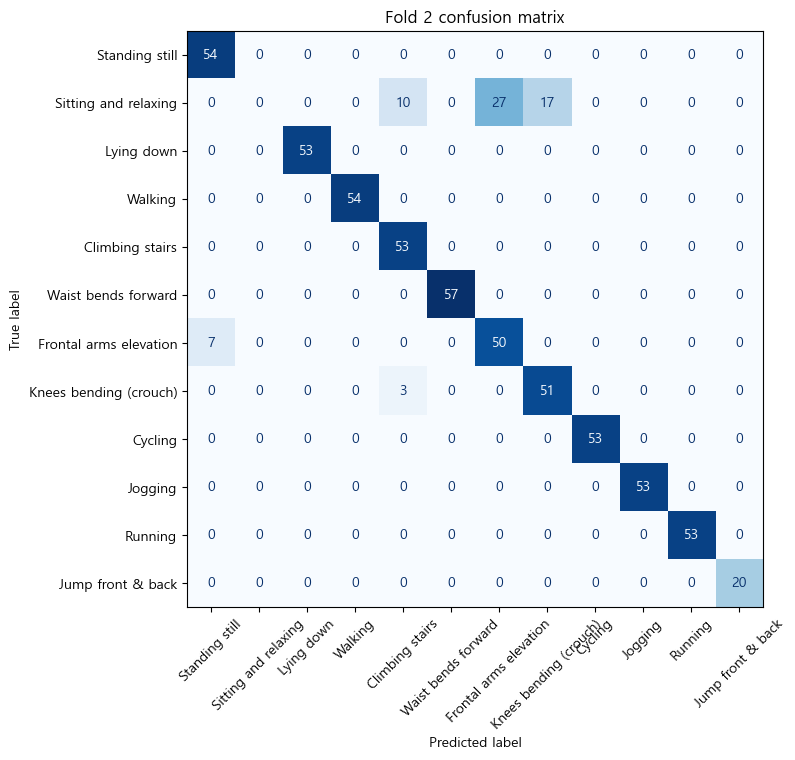

Fold 3: test=(5, 6), val=(7, 8), train=[1, 2, 3, 4, 9, 10]
Windows - train: 1816, val: 604, test: 578
  epoch 01 | train_loss=2.4075 acc=0.385 | val_loss=2.1616 acc=0.285
  epoch 05 | train_loss=0.5002 acc=0.852 | val_loss=1.2660 acc=0.603
  epoch 10 | train_loss=0.1389 acc=0.966 | val_loss=1.3800 acc=0.548
  epoch 15 | train_loss=0.1897 acc=0.931 | val_loss=1.4276 acc=0.586
  epoch 20 | train_loss=0.0468 acc=0.994 | val_loss=1.3790 acc=0.656
  epoch 25 | train_loss=0.0152 acc=0.999 | val_loss=1.5039 acc=0.636
  epoch 30 | train_loss=0.0810 acc=0.981 | val_loss=1.4730 acc=0.647
                        precision    recall  f1-score   support

        Standing still      0.370     0.500     0.425        54
  Sitting and relaxing      0.000     0.000     0.000        54
            Lying down      1.000     1.000     1.000        52
               Walking      0.000     0.000     0.000        52
       Climbing stairs      0.444     0.981     0.612        53
   Waist bends forward      0.

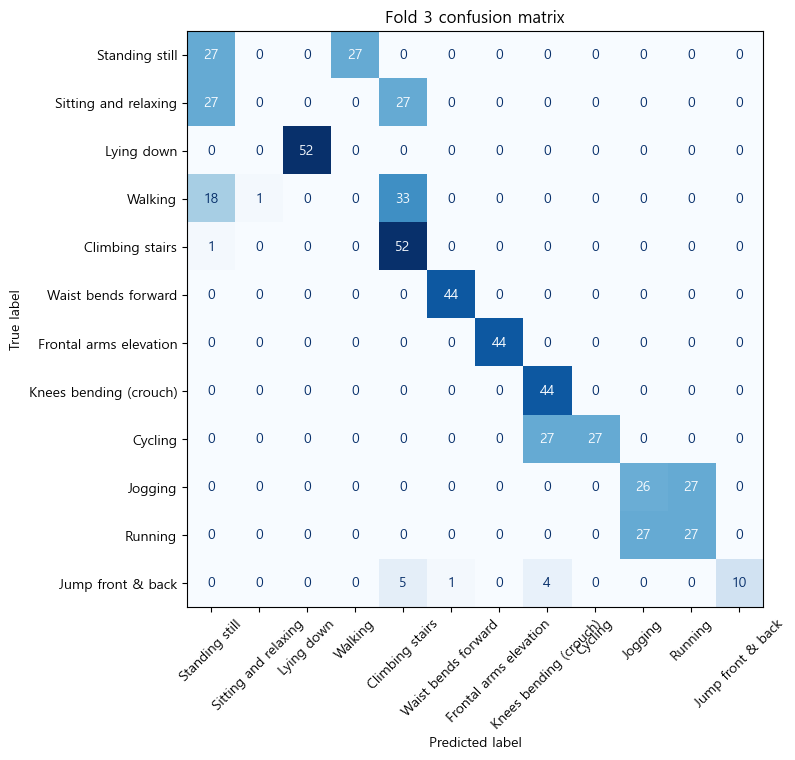

Fold 4: test=(7, 8), val=(9, 10), train=[1, 2, 3, 4, 5, 6]
Windows - train: 1806, val: 588, test: 604
  epoch 01 | train_loss=2.4047 acc=0.338 | val_loss=2.1258 acc=0.406
  epoch 05 | train_loss=0.4204 acc=0.841 | val_loss=0.7519 acc=0.770
  epoch 10 | train_loss=0.2048 acc=0.940 | val_loss=0.7882 acc=0.777
  epoch 15 | train_loss=0.0740 acc=0.982 | val_loss=0.2741 acc=0.929
  epoch 20 | train_loss=0.1954 acc=0.941 | val_loss=0.6553 acc=0.823
  epoch 25 | train_loss=0.0238 acc=0.997 | val_loss=0.2889 acc=0.913
  epoch 30 | train_loss=0.0127 acc=0.999 | val_loss=0.2991 acc=0.918
                        precision    recall  f1-score   support

        Standing still      0.869     0.981     0.922        54
  Sitting and relaxing      0.981     1.000     0.991        53
            Lying down      1.000     0.509     0.675        53
               Walking      0.971     0.623     0.759        53
       Climbing stairs      0.553     0.955     0.700        66
   Waist bends forward      0.

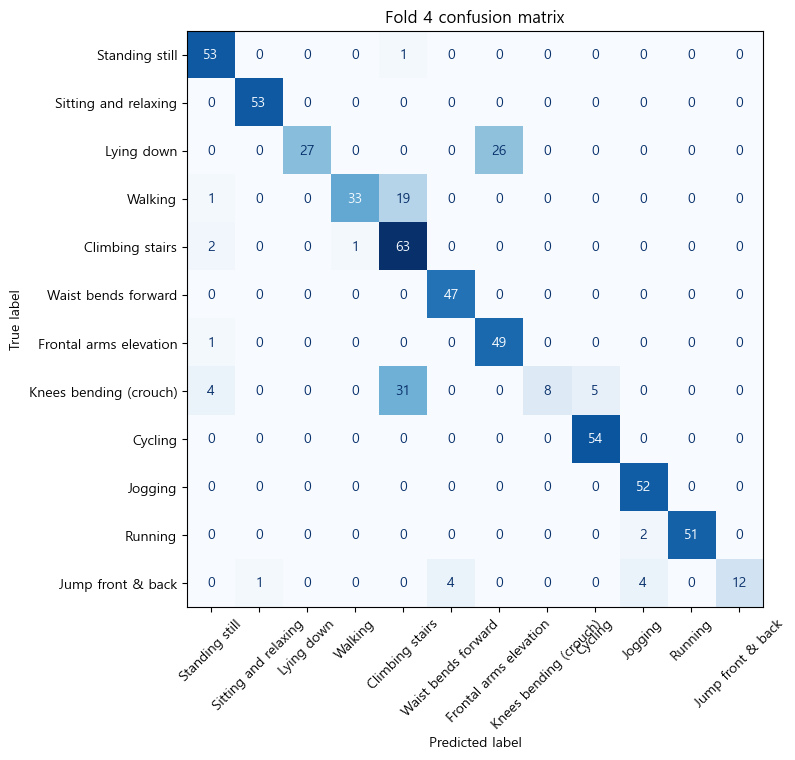

Fold 5: test=(9, 10), val=(1, 2), train=[3, 4, 5, 6, 7, 8]
Windows - train: 1797, val: 613, test: 588
  epoch 01 | train_loss=2.3929 acc=0.318 | val_loss=2.1563 acc=0.308
  epoch 05 | train_loss=0.4358 acc=0.878 | val_loss=0.8541 acc=0.706
  epoch 10 | train_loss=0.1978 acc=0.937 | val_loss=0.8726 acc=0.770
  epoch 15 | train_loss=0.0290 acc=0.997 | val_loss=0.9230 acc=0.799
  epoch 20 | train_loss=0.0347 acc=0.989 | val_loss=0.8565 acc=0.791
  epoch 25 | train_loss=0.0453 acc=0.992 | val_loss=0.7332 acc=0.749
  epoch 30 | train_loss=0.0480 acc=0.991 | val_loss=1.2428 acc=0.718
                        precision    recall  f1-score   support

        Standing still      1.000     1.000     1.000        53
  Sitting and relaxing      1.000     0.509     0.675        53
            Lying down      1.000     1.000     1.000        53
               Walking      1.000     0.500     0.667        52
       Climbing stairs      0.667     0.981     0.794        53
   Waist bends forward      0.

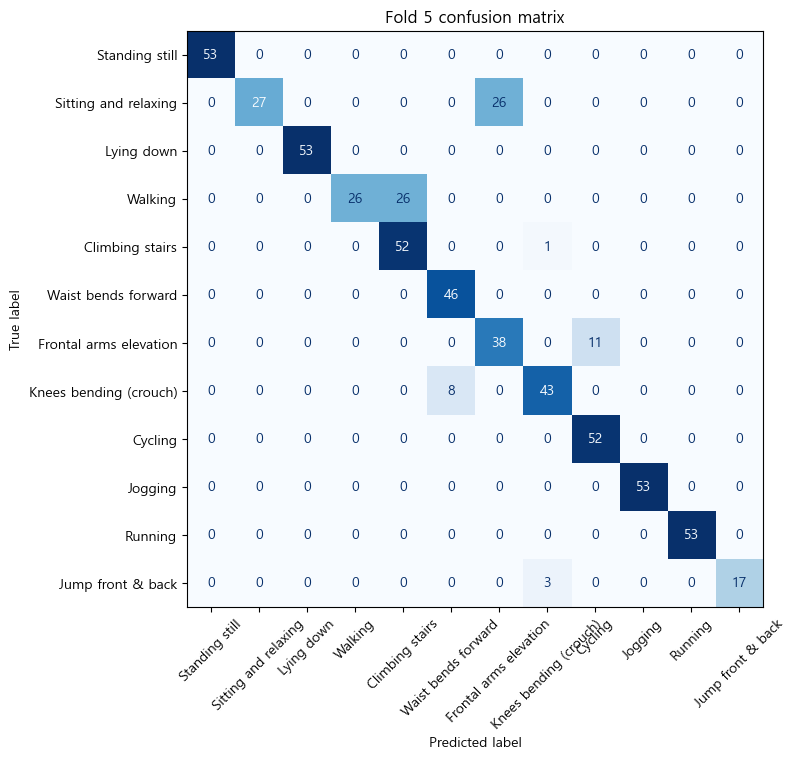

,fold,epoch,train_loss,train_acc,val_loss,val_acc
0,1,1,2.391678,0.327684,2.132952,0.513821
1,1,2,1.736509,0.418644,1.590503,0.577236
2,1,3,1.046832,0.689266,1.102640,0.759350
3,1,4,0.557084,0.848588,0.799403,0.830894
4,1,5,0.339640,0.905650,0.850623,0.834146
...,...,...,...,...,...,...
145,5,26,0.045472,0.988870,0.860340,0.738989
146,5,27,0.027246,0.994992,1.046516,0.747145
147,5,28,0.021740,0.995548,1.182099,0.722675
148,5,29,0.035636,0.991653,1.208183,0.735726


,fold,test_subjects,val_subjects,train_subjects,test_loss,test_acc,f1_macro
0,1,"(1, 2)","(3, 4)","(5, 6, 7, 8, 9, 10)",0.720502,0.791191,0.764059
1,2,"(3, 4)","(5, 6)","(1, 2, 7, 8, 9, 10)",0.736737,0.895935,0.867685
2,3,"(5, 6)","(7, 8)","(1, 2, 3, 4, 9, 10)",2.475939,0.610727,0.590760
3,4,"(7, 8)","(9, 10)","(1, 2, 3, 4, 5, 6)",0.727305,0.831126,0.807013
4,5,"(9, 10)","(1, 2)","(3, 4, 5, 6, 7, 8)",0.648459,0.872449,0.869079


Mean macro F1 across folds: 0.7797


In [11]:

GROUPED_SUBJECTS = [
    (1, 2),
    (3, 4),
    (5, 6),
    (7, 8),
    (9, 10),
]
all_subject_ids = [subject for group in GROUPED_SUBJECTS for subject in group]

config = TrainConfig()
device = config.device

fold_summaries: List[Dict[str, object]] = []
history_frames: List[pd.DataFrame] = []

for fold_idx, test_pair in enumerate(GROUPED_SUBJECTS):
    val_pair = GROUPED_SUBJECTS[(fold_idx + 1) % len(GROUPED_SUBJECTS)]
    train_subjects = sorted(set(all_subject_ids) - set(test_pair) - set(val_pair))

    print(f"Fold {fold_idx + 1}: test={test_pair}, val={val_pair}, train={train_subjects}")

    train_dataset = MHealthWindowDataset(train_subjects, window_size=250, step_size=125, normalization=normalization_stats)
    val_dataset = MHealthWindowDataset(val_pair, window_size=250, step_size=125, normalization=normalization_stats)
    test_dataset = MHealthWindowDataset(test_pair, window_size=250, step_size=125, normalization=normalization_stats)

    print(f"Windows - train: {len(train_dataset)}, val: {len(val_dataset)}, test: {len(test_dataset)}")
    if len(train_dataset) == 0 or len(val_dataset) == 0:
        raise RuntimeError("Empty dataset detected; adjust window or split configuration.")

    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, drop_last=False)
    val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)

    model = LSTMBaseline().to(device)
    class_weights = create_class_weights(train_dataset.targets.tolist(), ignore_zero=False).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)
    optimizer = torch.optim.AdamW(model.parameters(), lr=config.lr, weight_decay=config.weight_decay)

    best_state = copy.deepcopy(model.state_dict())
    best_val_acc = 0.0
    history: List[Dict[str, float]] = []

    for epoch in range(1, config.epochs + 1):
        train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, device, grad_clip=config.grad_clip)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)
        history.append(
            {
                "fold": fold_idx + 1,
                "epoch": epoch,
                "train_loss": train_loss,
                "train_acc": train_acc,
                "val_loss": val_loss,
                "val_acc": val_acc,
            }
        )
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_state = copy.deepcopy(model.state_dict())
        if epoch == 1 or epoch % 5 == 0:
            print(f"  epoch {epoch:02d} | train_loss={train_loss:.4f} acc={train_acc:.3f} | val_loss={val_loss:.4f} acc={val_acc:.3f}")

    model.load_state_dict(best_state)

    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    preds, targets = predict(model, test_loader, device)

    if f1_score is not None:
        fold_f1 = f1_score(
            targets,
            preds,
            labels=sorted(ACTIVITY_MAP.keys()),
            average="macro",
        )
    else:
        fold_f1 = float("nan")

    if classification_report is not None:
        report = classification_report(
            targets,
            preds,
            labels=sorted(ACTIVITY_MAP.keys()),
            target_names=[ACTIVITY_MAP[k] for k in sorted(ACTIVITY_MAP.keys())],
            digits=3,
        )
        print(report)
    else:
        print("Install scikit-learn to view detailed metrics.")

    if confusion_matrix is not None:
        cm = confusion_matrix(targets, preds, labels=sorted(ACTIVITY_MAP.keys()))
        disp = ConfusionMatrixDisplay(
            cm,
            display_labels=[ACTIVITY_MAP[k] for k in sorted(ACTIVITY_MAP.keys())],
        )
        fig, ax = plt.subplots(figsize=(8, 8))
        disp.plot(ax=ax, xticks_rotation=45, cmap="Blues", colorbar=False)
        ax.set_title(f"Fold {fold_idx + 1} confusion matrix")
        plt.tight_layout()
        plt.show()

    history_frames.append(pd.DataFrame(history))
    fold_summaries.append(
        {
            "fold": fold_idx + 1,
            "test_subjects": test_pair,
            "val_subjects": val_pair,
            "train_subjects": tuple(train_subjects),
            "test_loss": test_loss,
            "test_acc": test_acc,
            "f1_macro": fold_f1,
        }
    )

fold_history_df = pd.concat(history_frames, ignore_index=True)
display(fold_history_df)

fold_summary_df = pd.DataFrame(fold_summaries)
display(fold_summary_df)

if f1_score is not None:
    mean_f1 = fold_summary_df["f1_macro"].mean()
    print(f"Mean macro F1 across folds: {mean_f1:.4f}")
else:
    print("Mean F1 not available because scikit-learn is missing.")
